In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

In [11]:
# Pandas
import pandas as pd
import talib as ta
import numpy as np
# from get_score import get_score_ch
from sqlalchemy import create_engine
engine = create_engine('sqlite:///../dataset/us/us_ticker_price_yf.db')

In [12]:
df = pd.read_sql('AAPL',engine)

In [13]:
df

,open,hgih,low,close,Adj Close,volume,datetime
0,0.128348,0.128906,0.128348,0.128348,0.100178,469033600,1980-12-12
1,0.122210,0.122210,0.121652,0.121652,0.094952,175884800,1980-12-15
2,0.113281,0.113281,0.112723,0.112723,0.087983,105728000,1980-12-16
3,0.115513,0.116071,0.115513,0.115513,0.090160,86441600,1980-12-17
4,0.118862,0.119420,0.118862,0.118862,0.092774,73449600,1980-12-18
...,...,...,...,...,...,...,...
10480,145.259995,147.550003,145.000000,147.039993,147.039993,64493200,2022-07-08
10481,145.669998,146.639999,143.779999,144.869995,144.869995,63141600,2022-07-11
10482,145.759995,148.449997,145.050003,145.860001,145.860001,77588800,2022-07-12
10483,142.990005,146.449997,142.119995,145.490005,145.490005,71185600,2022-07-13


In [14]:
final_data = df

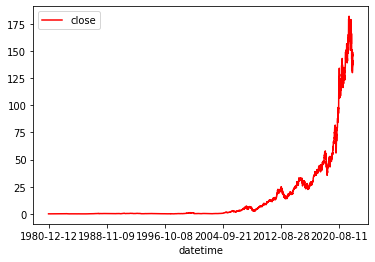

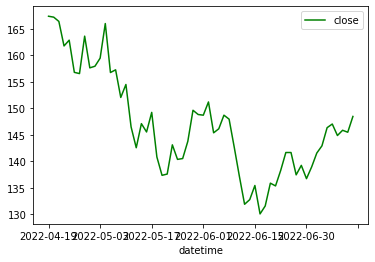

In [15]:
final_data.plot('datetime','close',color='red')

new_data = final_data.tail(60)

new_data.plot('datetime','close', color='green')

plt.show()

In [16]:
# 1. Filter out the closing market price data
close_data = final_data.filter(['close'])
 
# 2. Convert the data into array for easy evaluation
dataset = close_data.values
 
# 3. Scale/Normalize the data to make all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
# 4. Creating training data size : 70% of the data
training_data_len = math.ceil(len(dataset) *.7)
train_data = scaled_data[0:training_data_len  , : ]
 
# 5. Separating the data into x and y data
x_train_data=[]
y_train_data =[]
for i in range(60,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-60:i,0])
    y_train_data.append(train_data[i,0])
 
    # 6. Converting the training x and y values to numpy arrays
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
 
    # 7. Reshaping training s and y data to make the calculations easier
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))


In [17]:
# 5. 构建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

2022-08-01 14:28:02.081044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)

7280/7280 [==============================] - 474s 64ms/step - loss: 4.7767e-06


In [19]:
# 1. Creating a dataset for testing
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
 
# 2.  Convert the values into arrays for easier computation
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


99/99 [==============================] - 5s 31ms/step


In [21]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

9.697037983061012


In [28]:
data = pd.read_sql('AAPL',engine)

/var/folders/lz/kp_y7_p51sbc8gskvwtst_6h0000gp/T/ipykernel_40241/993920352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


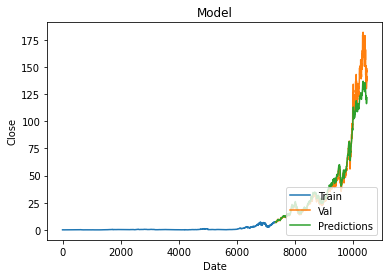

In [29]:
train = data[:training_data_len]
valid = data[training_data_len:] 
 
valid['Predictions'] = predictions                                                                                      
 
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
 
plt.show()